# Simulation results for k-model

In [1]:
import simpy 
import numpy as np
from heapq import *
import pandas as pd
import datetime
from datetime import timedelta
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import warnings
from simulation_functions import *

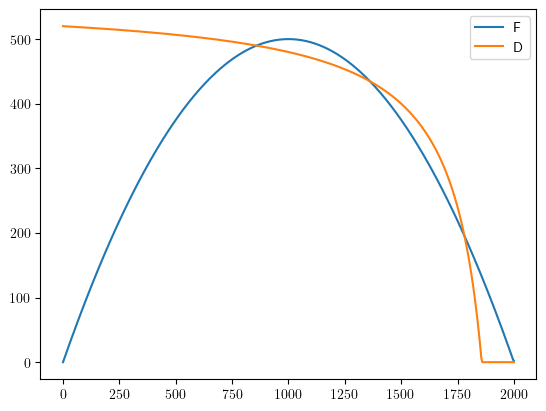

In [2]:
ks = np.linspace(0,kj,500)
plt.plot(ks,f(ks), label = 'F')
plt.plot(ks,D(μ(ks)), label = 'D')
plt.legend()

In [3]:
class Simulation():
    def __init__(self, start_density):
        self.li = [] 
        heapify(self.li)
        self.record= []
        self.cumm_curve = []
        self.travel = 0
        self.env = simpy.Environment()
        self.env.process(self.arrivals(self.env,self.li))
        self.traffic = self.env.process(self.traffic(self.env,self.li))
        self.start_density = start_density
        self.env.run(until=200)
    
    def get_record(self):
        df = pd.DataFrame(np.array(self.record),columns=('t','n','q','v','D', 'record type'))
        return df

    def get_cumm_curve(self):
        df = pd.DataFrame(np.array(self.cumm_curve), columns=('t','n','type'))
        return df
        
        
    def arrivals(self, env,li):
        #initialize
        for i in range(self.start_density):
            heappush(li,rnd_dev())

        
            
        while True:
            d = D(μ(len(li)))#the demand rate
            n = len(li)
            v = V(len(li))
            if d==0:
                yield env.timeout(0.05)
            else:
                yield env.timeout(rng.exponential(1/d))
                self.record.append([env.now,n,v*n,v,d,1])
                self.cumm_curve.append([env.now, n, 1])
                heappush(li,self.travel+rnd_dev())
                self.traffic.interrupt()

    def traffic(self,env,li):   
        while True:
            tr = nsmallest(1,li)[0]
            n = len(li)
            v = V(n)
            self.record.append([env.now,n,v*n,v,0,0])
            δ = (tr-self.travel)/v
            now = env.now
            try:
                yield env.timeout(δ)
                self.travel = heappop(li)
                self.cumm_curve.append([env.now, n,0])
            except simpy.Interrupt:
                self.travel = self.travel + (env.now - now)*v

In [4]:
sim1 = Simulation(1900)
sim2 = Simulation(1600)
sim3 = Simulation(1300)
sim4 = Simulation(10)

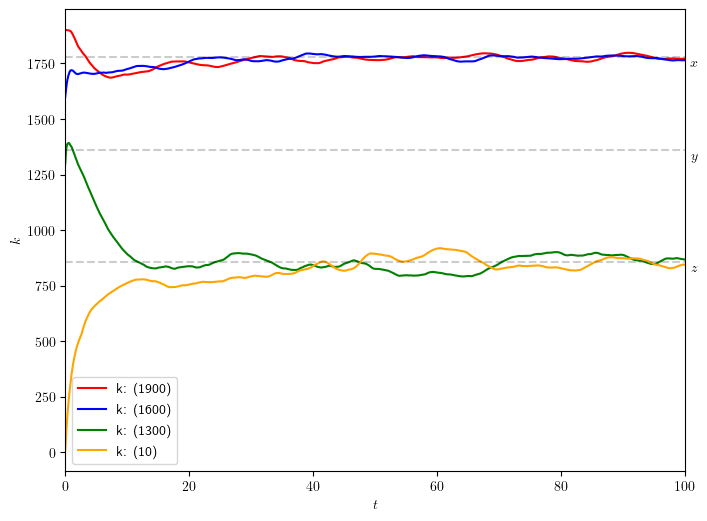

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    plot_Tn_curve([sim1, sim2, sim3, sim4], 'k', save = "../../fig/k_model/sim/logn_Tn.pdf")